# Global Climate Trends Analysis

 **Author**: Aaron Darcy  
 **Date**: November 2025  
 **Module**: Data Operations & Management

## Purpose
Analyse long-term global temperature anomaly trends using Berkeley Earth data,
ensuring sufficient global coverage and producing clean datasets for analysis
and Power BI visualisation.

## Datasets Used
- Berkeley Earth monthly country-level temperature anomaly data
- Source: https://berkeleyearth.org


In [1]:
# Import required libraries for HTTP requests, parsing, data handling and storage
import requests
from lxml import html
import pandas as pd
import unicodedata
import re
import os

# Mount Google Drive to persist outputs
from google.colab import drive
drive.mount('/content/drive')

# Define and create project directory
project_path = "/content/drive/MyDrive/ClimateProjectData"
os.makedirs(project_path, exist_ok=True)

# Display project path
project_path


Mounted at /content/drive


'/content/drive/MyDrive/ClimateProjectData'

## Step 1: Retrieve List of Countries

Scrape the Berkeley Earth website to obtain the list of countries
for which temperature data is available.


In [2]:
# Define headers to avoid request blocking
headers = {"User-Agent": "Mozilla/5.0"}

# URL containing the country list
url = "https://berkeleyearth.org/temperature-country-list/"

# Request page content
page = requests.get(url, headers=headers)

# Parse HTML
tree = html.fromstring(page.content)

# Extract country names from the table
countries = tree.xpath(
    '//table[contains(@class,"temperature-countries-list")]//tr/td[1]/a/text()'
)

# Inspect number of countries and preview
len(countries), countries[:10]


(237,
 ['Afghanistan',
  'Ã\x85land',
  'Albania',
  'Algeria',
  'American Samoa',
  'Andorra',
  'Angola',
  'Anguilla',
  'Antarctica',
  'Antigua and Barbuda'])

## Step 2: Normalise Country Names

Country names are converted into the format required by the
Berkeley Earth S3 bucket.


In [3]:
# Normalise country names to match S3 filenames
def normalise_country_name(name):
    # Remove accents
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")
    # Convert to lowercase
    name = name.lower()
    # Replace non-alphanumeric characters with hyphens
    name = re.sub(r'[^a-z0-9]+', '-', name)
    # Remove leading/trailing hyphens
    name = name.strip('-')
    return name

# Show sample transformations
sample = countries[:15]
for name in sample:
    print(f"{name}  -->  {normalise_country_name(name)}")


Afghanistan  -->  afghanistan
Ãland  -->  aland
Albania  -->  albania
Algeria  -->  algeria
American Samoa  -->  american-samoa
Andorra  -->  andorra
Angola  -->  angola
Anguilla  -->  anguilla
Antarctica  -->  antarctica
Antigua and Barbuda  -->  antigua-and-barbuda
Argentina  -->  argentina
Armenia  -->  armenia
Aruba  -->  aruba
Australia  -->  australia
Austria  -->  austria


## Step 3: Download and Parse Country Temperature Data

Each country’s temperature anomaly file is requested from the
Berkeley Earth S3 bucket. Metadata rows are ignored and valid
monthly records are parsed.


In [4]:
# Updated headers for bulk file requests
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0.0.0 Safari/537.36"
    )
}

# Storage for parsed country data
all_rows = []
success = 0
fail = 0

# Loop through all countries
for c in countries:
    # Normalise country name for filename
    clean = normalise_country_name(c)
    url = f"https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Regional/TAVG/{clean}-TAVG-Trend.txt"

    try:
        # Request data file
        r = requests.get(url, headers=headers)

        # Skip if file not found
        if r.status_code != 200:
            fail += 1
            print(f"FAILED: {c}")
            continue

        # Split file into lines
        lines = r.text.splitlines()

        # Remove metadata and empty lines
        data_lines = [ln for ln in lines if not ln.startswith("%") and ln.strip()]

        # Parse valid rows
        parsed = []
        for ln in data_lines:
            parts = ln.split()
            if len(parts) >= 3:
                year = int(parts[0])
                month = int(parts[1])
                anomaly = float(parts[2])
                parsed.append([c, year, month, anomaly])

        # Convert to DataFrame
        df_tmp = pd.DataFrame(parsed, columns=["country", "year", "month", "anomaly"])
        all_rows.append(df_tmp)

        success += 1
        print(f"SUCCESS: {c}")

    except:
        # Catch unexpected parsing or network errors
        fail += 1
        print(f"ERROR: {c}")


SUCCESS: Afghanistan
FAILED: Ãland
SUCCESS: Albania
SUCCESS: Algeria
SUCCESS: American Samoa
SUCCESS: Andorra
SUCCESS: Angola
SUCCESS: Anguilla
SUCCESS: Antarctica
SUCCESS: Antigua and Barbuda
SUCCESS: Argentina
SUCCESS: Armenia
SUCCESS: Aruba
SUCCESS: Australia
SUCCESS: Austria
SUCCESS: Azerbaijan
SUCCESS: Bahamas
SUCCESS: Bahrain
SUCCESS: Baker Island
SUCCESS: Bangladesh
SUCCESS: Barbados
SUCCESS: Belarus
SUCCESS: Belgium
SUCCESS: Belize
SUCCESS: Benin
SUCCESS: Bhutan
SUCCESS: Bolivia
FAILED: Bonaire, Saint Eustatius and Saba
SUCCESS: Bosnia and Herzegovina
SUCCESS: Botswana
SUCCESS: Brazil
SUCCESS: British Virgin Islands
SUCCESS: Bulgaria
SUCCESS: Burkina Faso
SUCCESS: Burma
SUCCESS: Burundi
SUCCESS: Cambodia
SUCCESS: Cameroon
SUCCESS: Canada
SUCCESS: Cape Verde
SUCCESS: Cayman Islands
SUCCESS: Central African Republic
SUCCESS: Chad
SUCCESS: Chile
SUCCESS: China
SUCCESS: Christmas Island
SUCCESS: Colombia
SUCCESS: Comoros
SUCCESS: Congo
FAILED: Congo (Democratic Republic of the)
SU

## Step 4: Combine All Country Data

Merge all successfully parsed country datasets into a single dataframe.


In [5]:
# Concatenate all country DataFrames if available
if all_rows:
    df_all_countries = pd.concat(all_rows, ignore_index=True)
else:
    df_all_countries = pd.DataFrame(columns=["country", "year", "month", "anomaly"])

# Preview combined dataset
df_all_countries.head()


,country,year,month,anomaly
0,Afghanistan,1848,5,-0.297
1,Afghanistan,1848,6,-0.796
2,Afghanistan,1848,7,-0.113
3,Afghanistan,1848,8,-0.462
4,Afghanistan,1848,9,-1.272


In [6]:
# Report ingestion results
print("Total countries:", len(countries))
print("Successful:", success)
print("Failed:", fail)

# Structural checks
print("Shape:", df_all_countries.shape)
print("Columns:", list(df_all_countries.columns))
print("Unique countries:", df_all_countries['country'].nunique())

# Check missing values
print("\nMissing values per column:")
print(df_all_countries.isnull().sum())

# Random sample for sanity check
df_all_countries.sample(5)


Total countries: 237
Successful: 226
Failed: 11
Shape: (515429, 4)
Columns: ['country', 'year', 'month', 'anomaly']
Unique countries: 226

Missing values per column:
country        0
year           0
month          0
anomaly    25328
dtype: int64


,country,year,month,anomaly
421165,Slovakia,1866,5,-2.394
295795,Mauritius,1839,12,NaN
423597,Slovenia,1798,1,0.936
167906,Georgia,2020,2,1.920
69324,British Virgin Islands,1914,4,-0.722


## Step 5: Global Data Coverage Analysis

Determine how many countries have data for each year and identify
the earliest year where coverage reaches at least 95%.


In [7]:
# Import plotting and numeric libraries
import matplotlib.pyplot as plt
import numpy as np

# Total number of countries in dataset
total_countries = df_all_countries["country"].nunique()
print("Total countries:", total_countries)

# Count number of countries with data per year
coverage = (
    df_all_countries
    .groupby("year")["country"]
    .nunique()
    .rename("countries_with_data")
    .reset_index()
)

# Compute coverage percentage
coverage["coverage_pct"] = (coverage["countries_with_data"] / total_countries) * 100

# Determine analysis window
min_year, max_year = coverage["year"].min(), coverage["year"].max()

# Identify first year with ≥95% coverage
cutoff_year = coverage[coverage["coverage_pct"] >= 95]["year"].min()
print(f"First year with ≥95% global coverage: {cutoff_year}")


Total countries: 226
First year with ≥95% global coverage: 1892


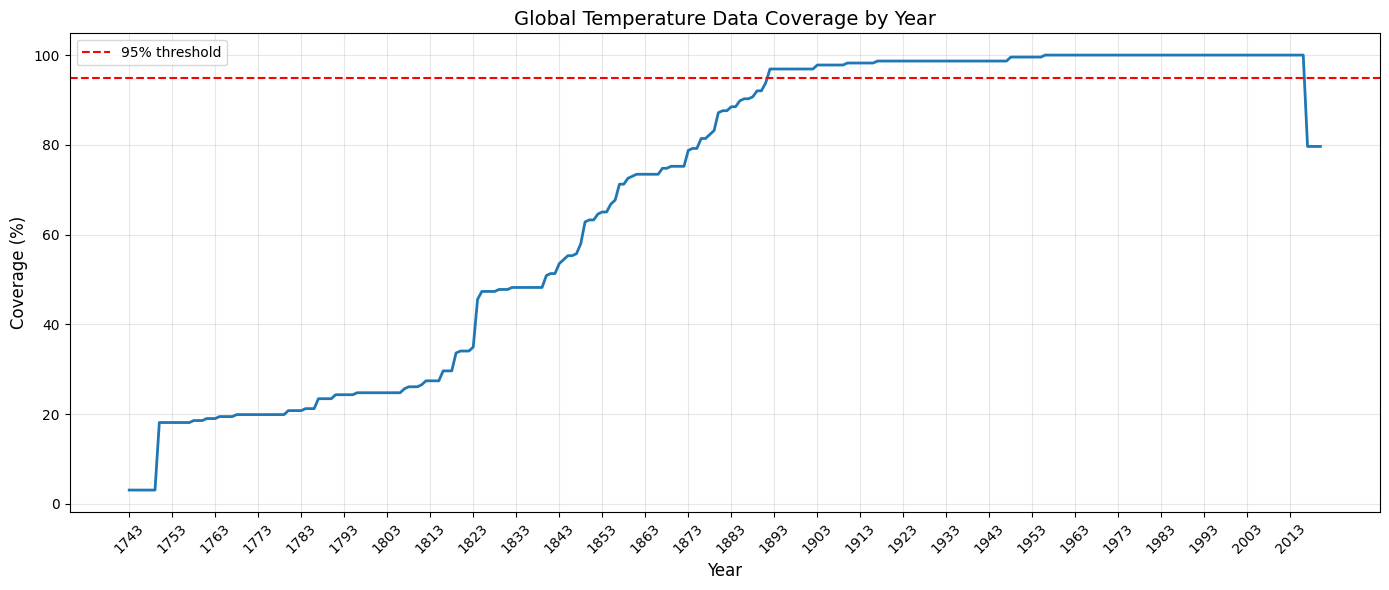

In [8]:
# Define x-axis tick spacing
tick_years = np.arange(min_year, max_year + 1, 10)

# Plot coverage over time
plt.figure(figsize=(14, 6))
plt.plot(coverage["year"], coverage["coverage_pct"], linewidth=2)
plt.axhline(95, color='red', linestyle='--', label='95% threshold')

# Chart formatting
plt.xticks(tick_years, rotation=45)
plt.title("Global Temperature Data Coverage by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Coverage (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Step 6: Filter Dataset

Restrict analysis to years where global data coverage
is at least 95%.


In [9]:
# Filter dataset to reliable coverage years
df_filtered = df_all_countries[df_all_countries["year"] >= cutoff_year].copy()

# Confirm filtering
print("Filtered dataset shape:", df_filtered.shape)
print("Year range:", df_filtered["year"].min(), "to", df_filtered["year"].max())

df_filtered.head()


Filtered dataset shape: (344422, 4)
Year range: 1892 to 2020


,country,year,month,anomaly
524,Afghanistan,1892,1,1.670
525,Afghanistan,1892,2,0.723
526,Afghanistan,1892,3,0.597
527,Afghanistan,1892,4,1.812
528,Afghanistan,1892,5,0.859


## Step 7: Global Aggregations

Create global monthly and annual average temperature anomalies.


In [10]:
# Monthly global averages
monthly_global = (
    df_filtered
    .groupby(["year", "month"])["anomaly"]
    .mean()
    .reset_index()
)

# Annual global averages
annual_global = (
    df_filtered
    .groupby("year")["anomaly"]
    .mean()
    .reset_index()
)

print("Monthly table:", monthly_global.shape)
print("Annual table:", annual_global.shape)

monthly_global.head(), annual_global.head()


Monthly table: (1548, 3)
Annual table: (129, 2)


(   year  month   anomaly
 0  1892      1 -0.456264
 1  1892      2 -0.307032
 2  1892      3 -0.816532
 3  1892      4 -0.448995
 4  1892      5 -0.549121,
    year   anomaly
 0  1892 -0.527766
 1  1893 -0.605066
 2  1894 -0.487558
 3  1895 -0.413521
 4  1896 -0.380984)

## Step 8: Feature Engineering (Per Observation)

Add seasonal labels, baseline anomalies, change from baseline,
and country-level anomaly z-scores.


In [11]:
# Assign meteorological seasons
def season(m):
    if m in [12, 1, 2]:
        return "Winter"
    if m in [3, 4, 5]:
        return "Spring"
    if m in [6, 7, 8]:
        return "Summer"
    return "Autumn"

df_filtered["season"] = df_filtered["month"].apply(season)

# Compute baseline anomaly (first available year per country)
baseline = (
    df_filtered.sort_values(["country", "year"])
               .groupby("country")
               .first()["anomaly"]
               .rename("baseline_anomaly")
)

# Join baseline back to main dataset
df_filtered = df_filtered.join(baseline, on="country")

# Calculate anomaly change from baseline
df_filtered["change_from_baseline"] = (
    df_filtered["anomaly"] - df_filtered["baseline_anomaly"]
)

# Compute country-level z-score
df_filtered["anomaly_zscore"] = (
    df_filtered.groupby("country")["anomaly"]
               .transform(lambda x: (x - x.mean()) / x.std())
)

df_filtered[["country","year","anomaly","baseline_anomaly",
             "change_from_baseline","anomaly_zscore","season"]].head()


,country,year,anomaly,baseline_anomaly,change_from_baseline,anomaly_zscore,season
524,Afghanistan,1892,1.670,1.67,0.000,1.081775,Winter
525,Afghanistan,1892,0.723,1.67,-0.947,0.426674,Winter
526,Afghanistan,1892,0.597,1.67,-1.073,0.339512,Spring
527,Afghanistan,1892,1.812,1.67,0.142,1.180005,Spring
528,Afghanistan,1892,0.859,1.67,-0.811,0.520754,Spring


## Step 9: Country-Level Feature Engineering

Generate long-term trend, volatility, mean anomaly,
and coverage statistics per country.


In [12]:
# Import modelling tools
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Work on a copy
df = df_filtered.copy()

# Compute linear trend per country
def compute_slope(sub):
    sub = sub.dropna(subset=["anomaly"])
    if len(sub) < 5:
        return np.nan

    X = sub["year"].values.reshape(-1, 1)
    y = sub["anomaly"].values

    model = LinearRegression().fit(X, y)
    return float(model.coef_[0])

# Trend per year
trend_per_year = (
    df.groupby("country")
      .apply(compute_slope)
      .rename("trend_per_year")
      .reset_index()
)

# Variability of anomalies
volatility = (
    df.groupby("country")["anomaly"]
      .std()
      .rename("volatility")
      .reset_index()
)

# Mean anomaly per country
mean_anomaly = (
    df.groupby("country")["anomaly"]
      .mean()
      .rename("mean_anomaly")
      .reset_index()
)

# Coverage statistics
coverage = (
    df.groupby("country")
      .agg(
          min_year=("year", "min"),
          max_year=("year", "max"),
          total_records=("anomaly", "count")
      )
      .reset_index()
)

# Merge into final feature table
df_features = (
    trend_per_year
    .merge(volatility, on="country")
    .merge(mean_anomaly, on="country")
    .merge(coverage, on="country")
)

print("Feature table shape:", df_features.shape)
df_features.head()


Feature table shape: (226, 7)


/tmp/ipython-input-2309655330.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_slope)


,country,trend_per_year,volatility,mean_anomaly,min_year,max_year,total_records
0,Afghanistan,0.012367,1.445580,0.106208,1892,2020,1548
1,Albania,0.010881,1.480545,0.153479,1892,2020,1548
2,Algeria,0.011663,1.080263,0.204998,1892,2020,1548
3,American Samoa,0.009898,0.534365,0.098793,1892,2020,1548
4,Andorra,0.011584,1.398797,0.276055,1892,2020,1548


## Step 10: Validation and Export

Perform final quality checks and export datasets
for Power BI and downstream analysis.


In [13]:
# Basic shape checks
print("=== BASIC SHAPE CHECKS ===")
print("df_filtered:", df_filtered.shape)
print("df_features:", df_features.shape)

# Column verification
print("\n=== COLUMN CHECKS ===")
print(df_features.columns)

# Missing value inspection
print("\n=== Missing Values ===")
print(df_features.isna().sum())

# Duplicate detection
print("\n=== Duplicate Country Entries ===")
dup = df_features['country'].duplicated().sum()
print("Duplicate rows:", dup)

if dup > 0:
    display(df_features[df_features['country'].duplicated(keep=False)])

# Year coverage validation
print("\n=== Year Coverage Checks ===")
year_stats = df_filtered.groupby("country")["year"].agg(["min", "max", "count"])
display(year_stats.head())

# Outlier analysis
print("\n=== Outlier Check: Trend per Year (99th percentile) ===")
p01 = df_features["trend_per_year"].quantile(0.01)
p99 = df_features["trend_per_year"].quantile(0.99)
print("1st percentile:", p01)
print("99th percentile:", p99)

outliers = df_features[
    (df_features["trend_per_year"] < p01) |
    (df_features["trend_per_year"] > p99)
]

print("Outliers:", outliers.shape[0])
display(outliers.head())

# Summary statistics
print("\n=== Summary Statistics for All Features ===")
display(df_features.describe())

# Export datasets
df_filtered.to_csv(project_path + "/temperature_data_clean.csv", index=False)
df_features.to_csv(project_path + "/country_features.csv", index=False)

df_features.head(12)


=== BASIC SHAPE CHECKS ===
df_filtered: (344422, 8)
df_features: (226, 7)

=== COLUMN CHECKS ===
Index(['country', 'trend_per_year', 'volatility', 'mean_anomaly', 'min_year',
       'max_year', 'total_records'],
      dtype='object')

=== Missing Values ===
country           0
trend_per_year    0
volatility        0
mean_anomaly      0
min_year          0
max_year          0
total_records     0
dtype: int64

=== Duplicate Country Entries ===
Duplicate rows: 0

=== Year Coverage Checks ===


,min,max,count
country,,,
Afghanistan,1892,2020,1548
Albania,1892,2020,1548
Algeria,1892,2020,1548
American Samoa,1892,2020,1548
Andorra,1892,2020,1548



=== Outlier Check: Trend per Year (99th percentile) ===
1st percentile: 0.007498821965440626
99th percentile: 0.015938102494972118
Outliers: 6


,country,trend_per_year,volatility,mean_anomaly,min_year,max_year,total_records
7,Antarctica,0.017874,1.190977,0.360017,1956,2020,780
93,India,0.006875,0.674901,0.027908,1892,2020,1548
131,Mexico,0.007369,0.637680,-0.027009,1892,2020,1548
134,Mongolia,0.016474,1.843609,0.197962,1892,2020,1548
192,Sri Lanka,0.006292,0.460059,0.143844,1892,2020,1548



=== Summary Statistics for All Features ===


,trend_per_year,volatility,mean_anomaly,min_year,max_year,total_records
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,0.010980,0.998619,0.101567,1893.066372,2019.185841,1521.752212
std,0.001724,0.515545,0.109272,7.087392,1.614097,91.445287
min,0.006292,0.457431,-0.122450,1892.000000,2016.000000,780.000000
25%,0.009995,0.585220,0.012425,1892.000000,2020.000000,1543.750000
50%,0.010638,0.771837,0.099024,1892.000000,2020.000000,1548.000000
75%,0.011910,1.264596,0.178747,1892.000000,2020.000000,1548.000000
max,0.017874,2.483852,0.400694,1956.000000,2020.000000,1548.000000


,country,trend_per_year,volatility,mean_anomaly,min_year,max_year,total_records
0,Afghanistan,0.012367,1.445580,0.106208,1892,2020,1548
1,Albania,0.010881,1.480545,0.153479,1892,2020,1548
2,Algeria,0.011663,1.080263,0.204998,1892,2020,1548
3,American Samoa,0.009898,0.534365,0.098793,1892,2020,1548
4,Andorra,0.011584,1.398797,0.276055,1892,2020,1548
5,Angola,0.010827,0.667969,0.233996,1892,2020,1543
6,Anguilla,0.010333,0.524840,-0.034291,1892,2016,1493
7,Antarctica,0.017874,1.190977,0.360017,1956,2020,780
8,Antigua and Barbuda,0.011389,0.570570,0.014795,1892,2020,1548
9,Argentina,0.009100,0.939925,0.007202,1892,2020,1548


## Final Result: Interactive Power BI Dashboard

The processed datasets were imported into Power BI to create an interactive dashboard for analysing global climate trends.

### Overview
- Uses cleaned monthly temperature anomalies and country-level engineered features
- Supports exploration at both global and country level

### Key Features
- **Global trends**: Line charts showing long-term annual and monthly temperature anomalies  
- **Country analysis**: Interactive map and slicers to compare countries over time  
- **Seasonal insights**: Breakdown of anomalies by season  
- **Trend & variability**: Visuals highlighting warming rate and volatility per country  

### Interactivity
- Slicers for country, year range, and season  
- Cross-filtering and tooltips for drill-down analysis  

### Outcome
The dashboard provides a clear, interactive way to explore and compare climate trends across countries and time periods.


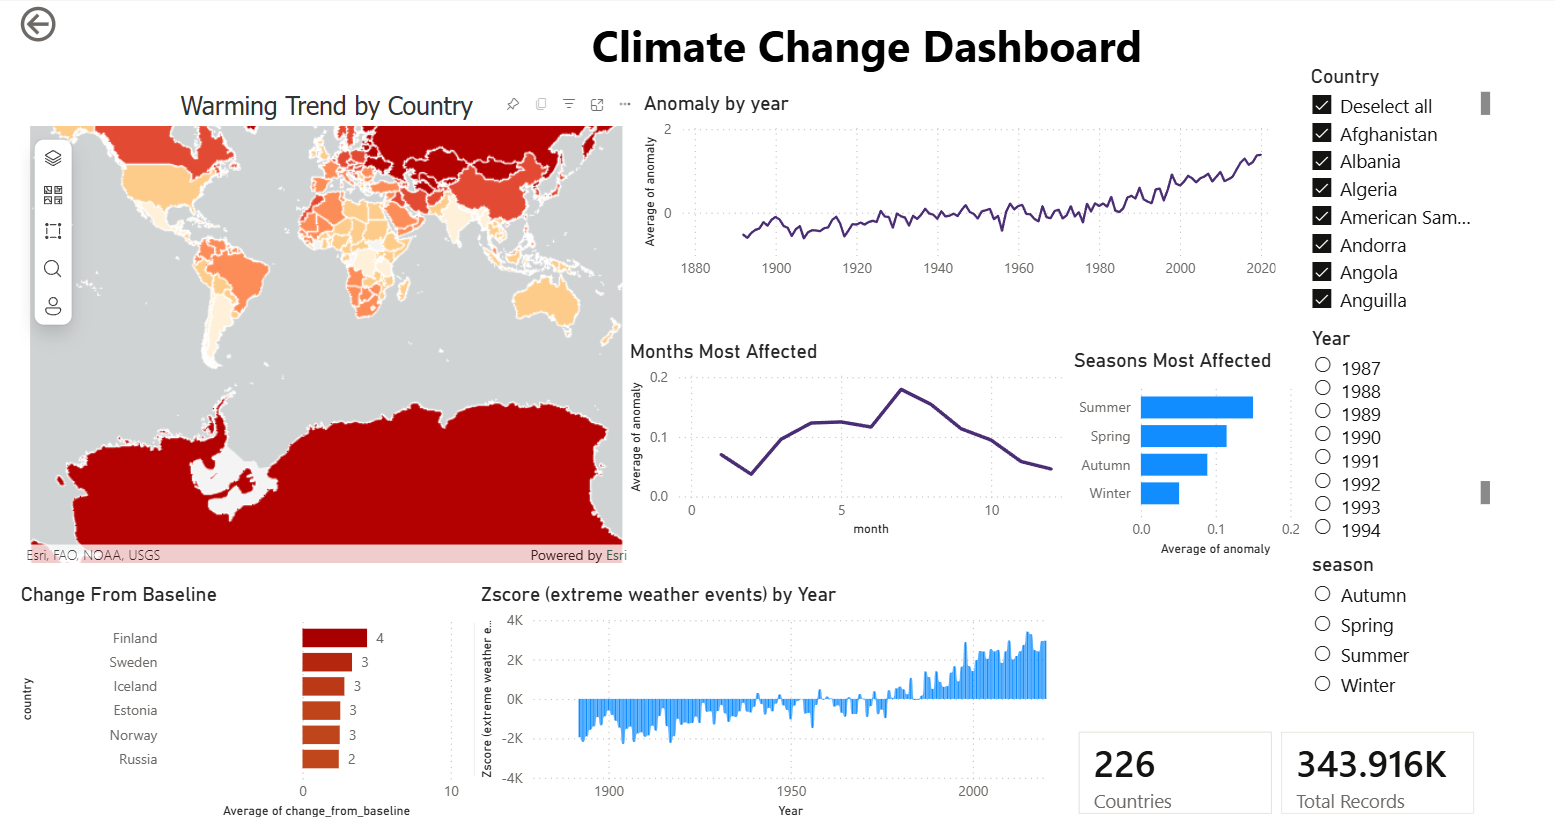